<a href="https://colab.research.google.com/github/youbodib/LeNet-5/blob/main/LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================
# 1. Importations & Préparation
# =============================
import os, copy, zipfile
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np

In [ ]:
# =============================
# 2. Upload & Extraction
# =============================
uploaded = files.upload()
zip_filename = next(iter(uploaded))
extract_dir = './tifinagh-data'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Contenu du dossier extrait :", os.listdir(extract_dir))
for root, dirs, files_ in os.walk(extract_dir):
    print(f"Dossier : {root}\nSous-dossiers : {dirs}\nFichiers : {files_[:5]}\n{'-'*40}")

Saving data_tifinagh.zip to data_tifinagh.zip
Contenu du dossier extrait : ['__MACOSX', 'amhcd-data-64']
Dossier : ./tifinagh-data
Sous-dossiers : ['__MACOSX', 'amhcd-data-64']
Fichiers : []
----------------------------------------
Dossier : ./tifinagh-data/__MACOSX
Sous-dossiers : ['amhcd-data-64']
Fichiers : []
----------------------------------------
Dossier : ./tifinagh-data/__MACOSX/amhcd-data-64
Sous-dossiers : []
Fichiers : ['._labels-map.csv', '._.DS_Store']
----------------------------------------
Dossier : ./tifinagh-data/amhcd-data-64
Sous-dossiers : ['tifinagh-images']
Fichiers : ['.DS_Store', 'labels-map.csv']
----------------------------------------
Dossier : ./tifinagh-data/amhcd-data-64/tifinagh-images
Sous-dossiers : ['yazz', 'yas', 'yadd', 'yat', 'yaz', 'yal', 'yach', 'yakk', 'yay', 'yam', 'yad', 'yahh', 'yah', 'yarr', 'ya', 'yae', 'yey', 'yaf', 'yass', 'yak', 'yagh', 'yaq', 'yaw', 'yu', 'yan', 'yaj', 'yax', 'yagg', 'yag', 'yab', 'yi', 'yar', 'yatt']
Fichiers : []
---

In [ ]:
# =============================
# 3. Dataset Robuste
# =============================
class TifinaghDataset(Dataset):
    IMG_EXTENSIONS = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.ppm')

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            if not os.path.isdir(class_path): continue
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_name.lower().endswith(self.IMG_EXTENSIONS):
                    try:
                        with Image.open(img_path) as img:
                            img.verify()
                        self.samples.append((img_path, label))
                    except Exception as e:
                        print(f"Warning: Impossible de lire l'image {img_path} ({e}) — ignorée.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('L')
        except Exception as e:
            raise RuntimeError(f"Erreur lors de la lecture de {img_path}: {e}")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# =============================
# 4. Data Augmentation / Split
# =============================
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),# <--- Data augmentation : rotations aléatoires
    transforms.RandomAffine(0, translate=(0.1,0.1)),# <--- Data augmentation : translation aléatoire
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.02*torch.randn_like(x)),  # Ajoute un bruit léger (gaussien)
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

DATA_ROOT = './tifinagh-data/amhcd-data-64/tifinagh-images'
dataset_full = TifinaghDataset(DATA_ROOT, transform=None)
total_size = len(dataset_full)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

generator = torch.Generator().manual_seed(42)
train_indices, test_indices = torch.utils.data.random_split(
    range(total_size), [train_size, test_size], generator=generator
)

#  gardez le même split pour tous les tests
dataset_train = copy.deepcopy(dataset_full)
dataset_train.transform = transform_train
dataset_test = copy.deepcopy(dataset_full)
dataset_test.transform = transform_test

train_dataset = Subset(dataset_train, train_indices.indices)
test_dataset = Subset(dataset_test, test_indices.indices)

class_names = dataset_full.classes

In [ ]:
# =============================
# 5. Modèle LeNet-5
# =============================
def conv_layer(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

def pool_layer(kernel_size=2, stride=2, mode='avg'):
    return nn.AvgPool2d(kernel_size, stride) if mode == 'avg' else nn.MaxPool2d(kernel_size, stride)

def fc_layer(in_features, out_features):
    return nn.Linear(in_features, out_features)

class LeNet5(nn.Module):
    def __init__(self, num_classes=33,
                 conv1_params=(1, 6, 5, 1, 0), pool1_params=(2, 2, 'avg'),
                 conv2_params=(6, 16, 5, 1, 0), pool2_params=(2, 2, 'avg'),
                 conv3_params=(16, 120, 5, 1, 0),
                 fc1_params=(120, 84), fc2_params=None):
        super().__init__()
        self.conv1 = conv_layer(*conv1_params)
        self.pool1 = pool_layer(*pool1_params)
        self.conv2 = conv_layer(*conv2_params)
        self.pool2 = pool_layer(*pool2_params)
        self.conv3 = conv_layer(*conv3_params)
        self.fc1 = fc_layer(*fc1_params)
        if fc2_params is None:
            fc2_params = (fc1_params[1], num_classes)
        self.fc2 = fc_layer(*fc2_params)

    def forward(self, x, verbose=False):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# =============================
# 6. Train/Eval Functions
# =============================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

def get_optimizer(name, parameters, lr=0.001):
    name = name.lower()
    if name == "adam": return torch.optim.Adam(parameters, lr=lr)
    if name == "sgd": return torch.optim.SGD(parameters, lr=lr, momentum=0.9)
    if name == "rmsprop": return torch.optim.RMSprop(parameters, lr=lr)
    if name == "adagrad": return torch.optim.Adagrad(parameters, lr=lr)
    if name == "adadelta": return torch.optim.Adadelta(parameters, lr=lr)
    raise ValueError(f"Optimiseur inconnu : {name}")

Taille train_dataset : 22545
Taille test_dataset  : 5637
Nombre de classes   : 33
Exemple 0 : (tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 10)


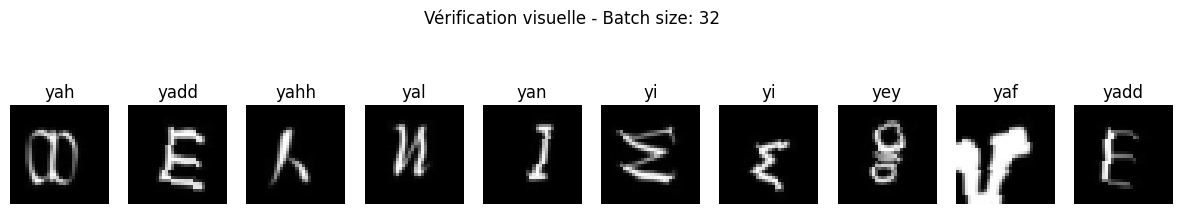


=== Batch: 32 | Optimizer: ADAM ===
Epoch 1 | Train Acc: 0.290 | Val Acc: 0.611 | LR: 0.00100
Epoch 2 | Train Acc: 0.611 | Val Acc: 0.756 | LR: 0.00100
Epoch 3 | Train Acc: 0.722 | Val Acc: 0.846 | LR: 0.00100
Epoch 4 | Train Acc: 0.780 | Val Acc: 0.869 | LR: 0.00100
Epoch 5 | Train Acc: 0.806 | Val Acc: 0.888 | LR: 0.00100
Epoch 6 | Train Acc: 0.838 | Val Acc: 0.918 | LR: 0.00100
Epoch 7 | Train Acc: 0.856 | Val Acc: 0.921 | LR: 0.00100
Epoch 8 | Train Acc: 0.865 | Val Acc: 0.929 | LR: 0.00100
Epoch 9 | Train Acc: 0.876 | Val Acc: 0.925 | LR: 0.00100
Epoch 10 | Train Acc: 0.882 | Val Acc: 0.930 | LR: 0.00100


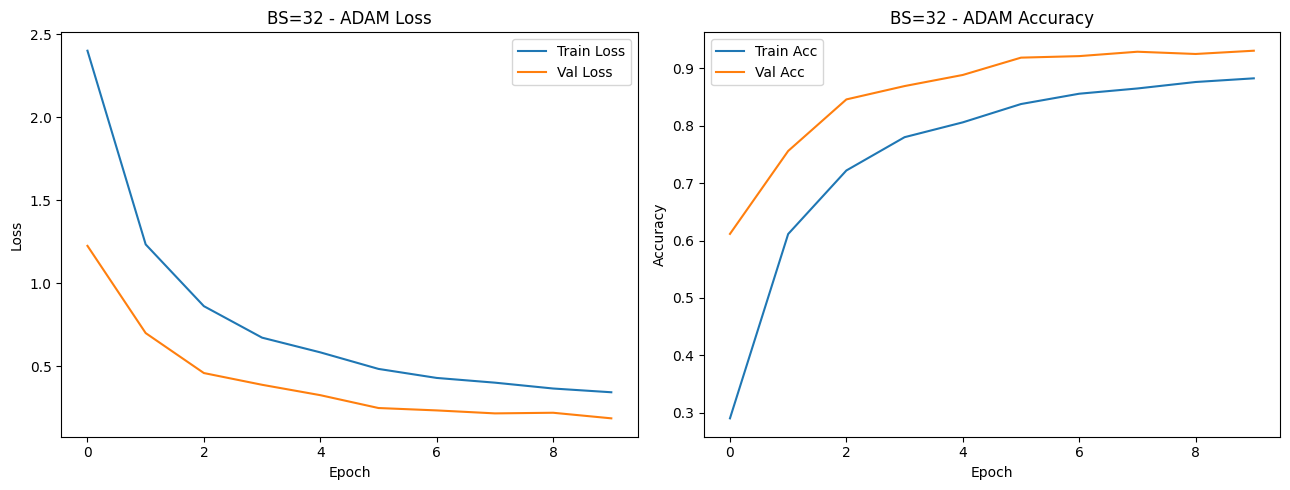


=== Batch: 32 | Optimizer: SGD ===
Epoch 1 | Train Acc: 0.032 | Val Acc: 0.058 | LR: 0.00100
Epoch 2 | Train Acc: 0.042 | Val Acc: 0.069 | LR: 0.00100
Epoch 3 | Train Acc: 0.093 | Val Acc: 0.185 | LR: 0.00100
Epoch 4 | Train Acc: 0.193 | Val Acc: 0.309 | LR: 0.00100
Epoch 5 | Train Acc: 0.278 | Val Acc: 0.384 | LR: 0.00100
Epoch 6 | Train Acc: 0.359 | Val Acc: 0.495 | LR: 0.00100
Epoch 7 | Train Acc: 0.455 | Val Acc: 0.594 | LR: 0.00100
Epoch 8 | Train Acc: 0.507 | Val Acc: 0.623 | LR: 0.00100
Epoch 9 | Train Acc: 0.549 | Val Acc: 0.669 | LR: 0.00100
Epoch 10 | Train Acc: 0.581 | Val Acc: 0.673 | LR: 0.00100


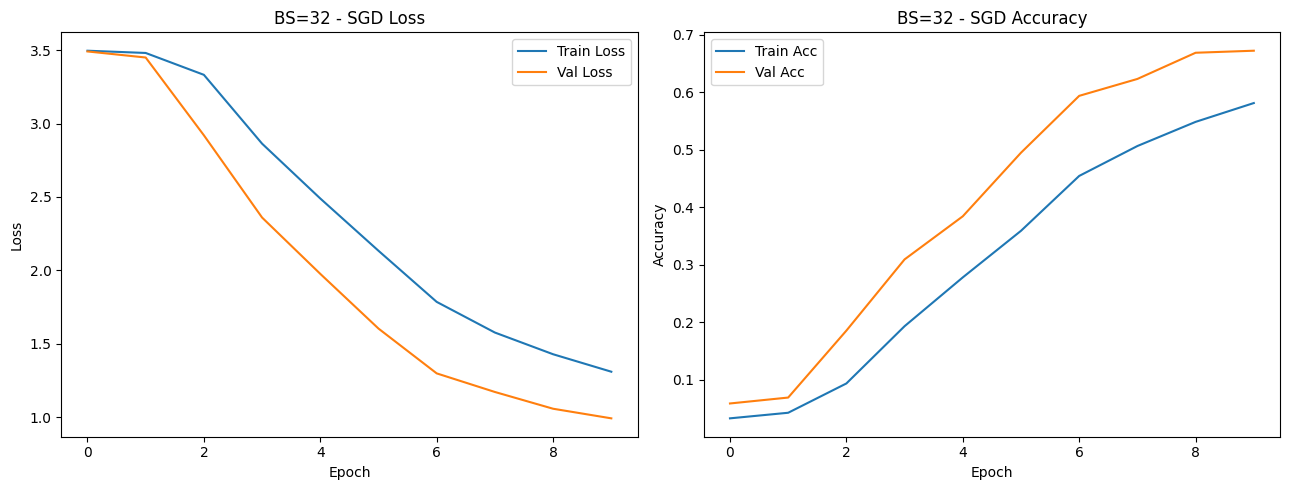


=== Batch: 32 | Optimizer: RMSPROP ===
Epoch 1 | Train Acc: 0.310 | Val Acc: 0.584 | LR: 0.00100
Epoch 2 | Train Acc: 0.564 | Val Acc: 0.676 | LR: 0.00100
Epoch 3 | Train Acc: 0.657 | Val Acc: 0.799 | LR: 0.00100
Epoch 4 | Train Acc: 0.720 | Val Acc: 0.838 | LR: 0.00100
Epoch 5 | Train Acc: 0.763 | Val Acc: 0.830 | LR: 0.00100
Epoch 6 | Train Acc: 0.794 | Val Acc: 0.739 | LR: 0.00100
Epoch 7 | Train Acc: 0.811 | Val Acc: 0.870 | LR: 0.00100
Epoch 8 | Train Acc: 0.832 | Val Acc: 0.906 | LR: 0.00100
Epoch 9 | Train Acc: 0.844 | Val Acc: 0.900 | LR: 0.00100
Epoch 10 | Train Acc: 0.859 | Val Acc: 0.915 | LR: 0.00100


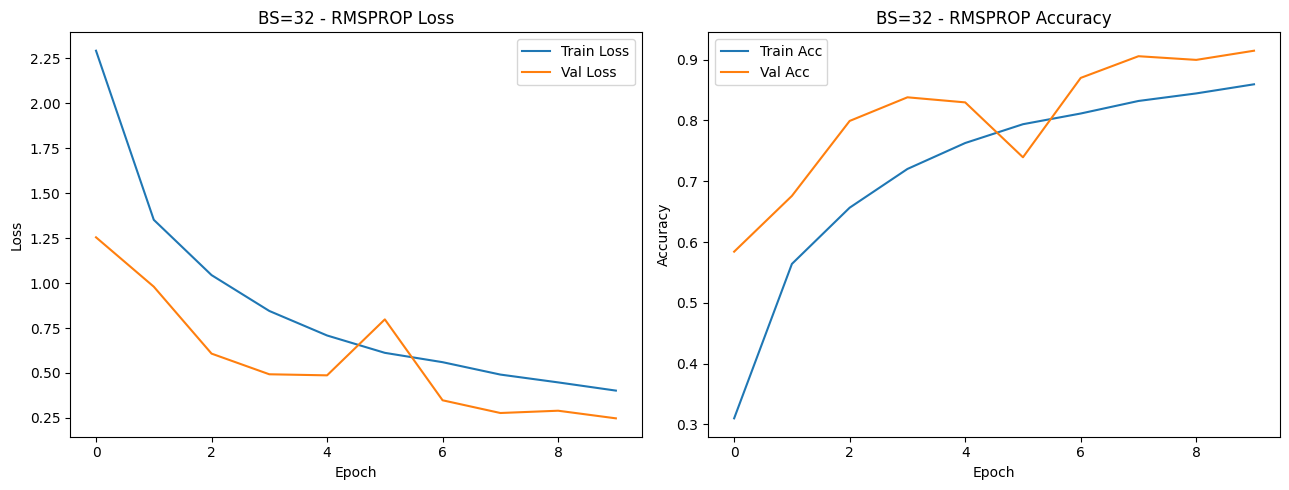


=== Batch: 32 | Optimizer: ADAGRAD ===
Epoch 1 | Train Acc: 0.074 | Val Acc: 0.158 | LR: 0.00100
Epoch 2 | Train Acc: 0.145 | Val Acc: 0.219 | LR: 0.00100
Epoch 3 | Train Acc: 0.176 | Val Acc: 0.267 | LR: 0.00100
Epoch 4 | Train Acc: 0.196 | Val Acc: 0.276 | LR: 0.00100
Epoch 5 | Train Acc: 0.213 | Val Acc: 0.283 | LR: 0.00100
Epoch 6 | Train Acc: 0.222 | Val Acc: 0.325 | LR: 0.00100
Epoch 7 | Train Acc: 0.233 | Val Acc: 0.332 | LR: 0.00100
Epoch 8 | Train Acc: 0.241 | Val Acc: 0.343 | LR: 0.00100
Epoch 9 | Train Acc: 0.249 | Val Acc: 0.350 | LR: 0.00100
Epoch 10 | Train Acc: 0.257 | Val Acc: 0.359 | LR: 0.00100


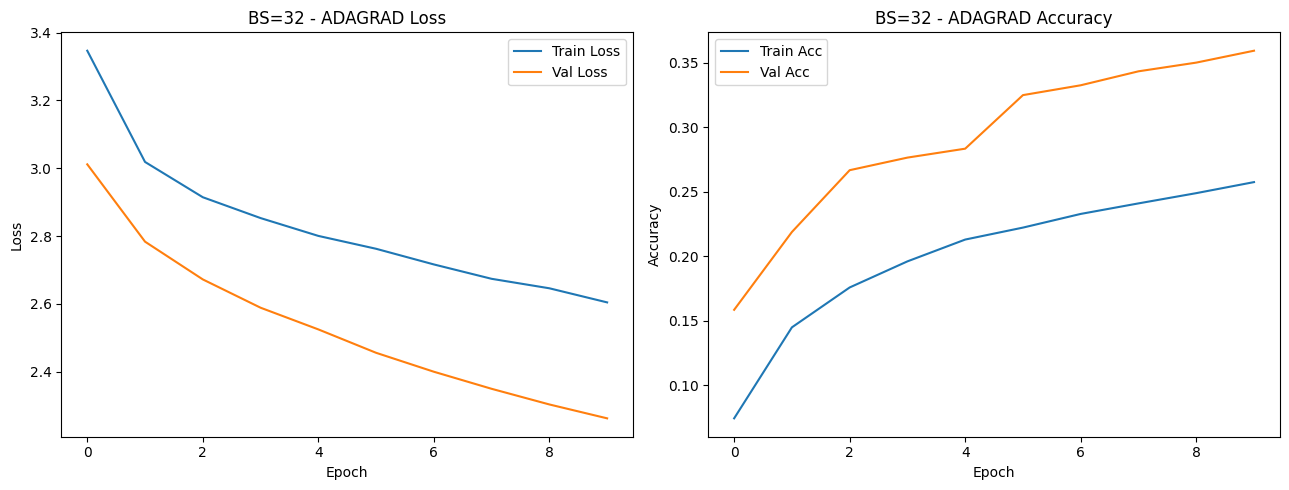


=== Batch: 32 | Optimizer: ADADELTA ===
Epoch 1 | Train Acc: 0.030 | Val Acc: 0.032 | LR: 0.00100
Epoch 2 | Train Acc: 0.030 | Val Acc: 0.032 | LR: 0.00100
Epoch 3 | Train Acc: 0.030 | Val Acc: 0.032 | LR: 0.00100
Epoch 4 | Train Acc: 0.030 | Val Acc: 0.032 | LR: 0.00100
Epoch 5 | Train Acc: 0.030 | Val Acc: 0.032 | LR: 0.00100
Epoch 6 | Train Acc: 0.030 | Val Acc: 0.033 | LR: 0.00100
Epoch 7 | Train Acc: 0.035 | Val Acc: 0.042 | LR: 0.00100
Epoch 8 | Train Acc: 0.043 | Val Acc: 0.049 | LR: 0.00100
Epoch 9 | Train Acc: 0.046 | Val Acc: 0.045 | LR: 0.00100
Epoch 10 | Train Acc: 0.045 | Val Acc: 0.042 | LR: 0.00100


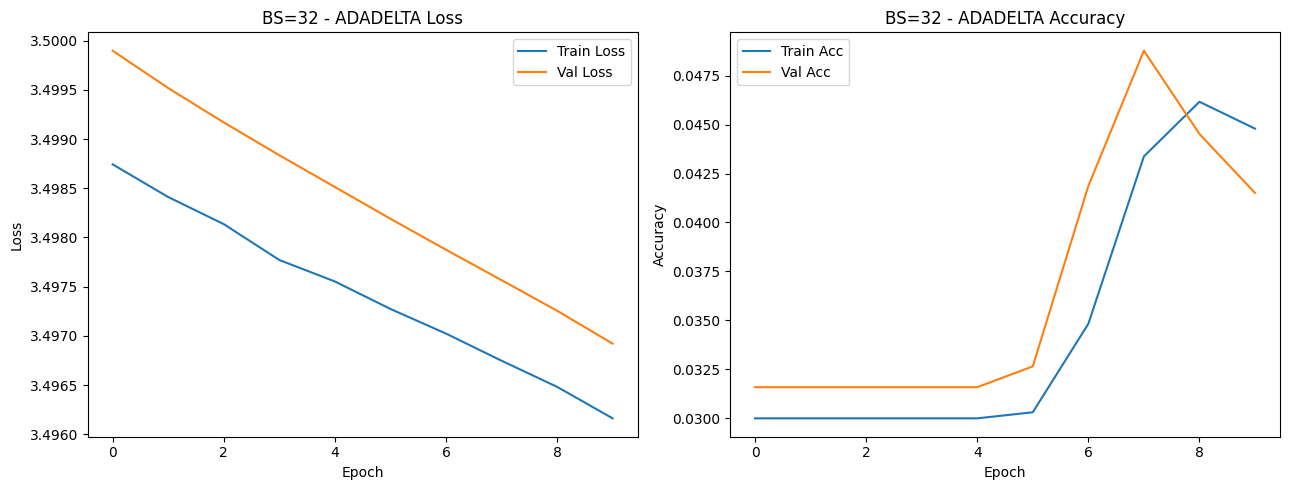

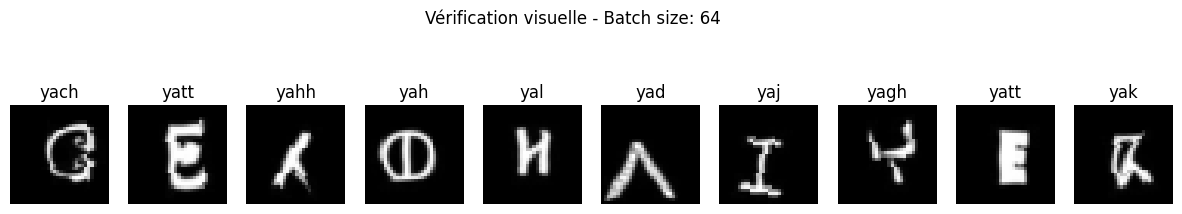


=== Batch: 64 | Optimizer: ADAM ===
Epoch 1 | Train Acc: 0.197 | Val Acc: 0.465 | LR: 0.00100
Epoch 2 | Train Acc: 0.483 | Val Acc: 0.632 | LR: 0.00100
Epoch 3 | Train Acc: 0.621 | Val Acc: 0.724 | LR: 0.00100
Epoch 4 | Train Acc: 0.689 | Val Acc: 0.786 | LR: 0.00100
Epoch 5 | Train Acc: 0.732 | Val Acc: 0.830 | LR: 0.00100
Epoch 6 | Train Acc: 0.759 | Val Acc: 0.849 | LR: 0.00100
Epoch 7 | Train Acc: 0.792 | Val Acc: 0.855 | LR: 0.00100
Epoch 8 | Train Acc: 0.804 | Val Acc: 0.872 | LR: 0.00100
Epoch 9 | Train Acc: 0.821 | Val Acc: 0.901 | LR: 0.00100
Epoch 10 | Train Acc: 0.834 | Val Acc: 0.909 | LR: 0.00100


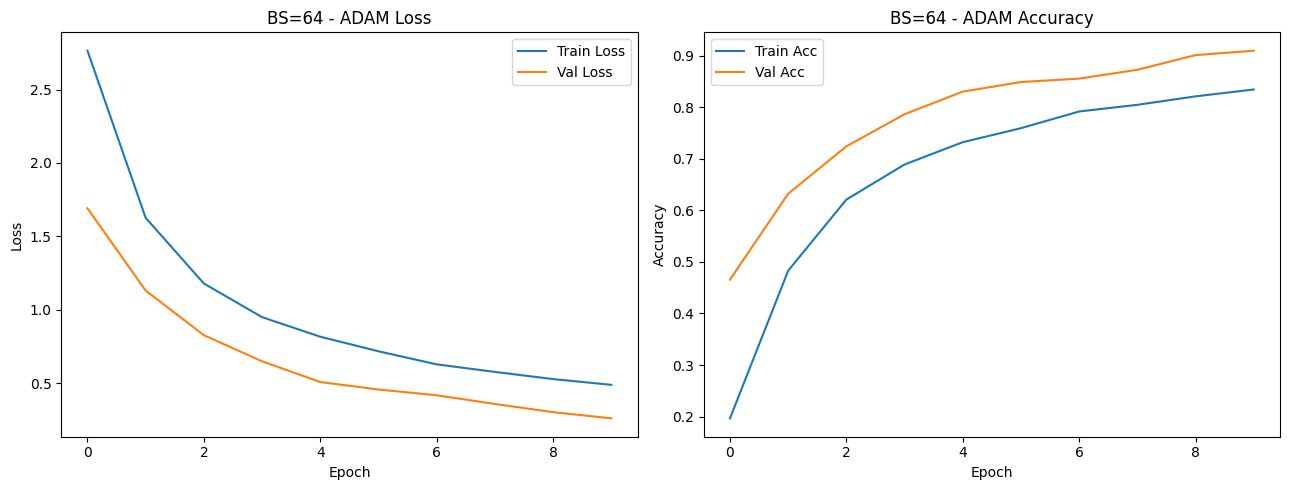


=== Batch: 64 | Optimizer: SGD ===
Epoch 1 | Train Acc: 0.030 | Val Acc: 0.031 | LR: 0.00100
Epoch 2 | Train Acc: 0.033 | Val Acc: 0.042 | LR: 0.00100
Epoch 3 | Train Acc: 0.044 | Val Acc: 0.050 | LR: 0.00100
Epoch 4 | Train Acc: 0.058 | Val Acc: 0.083 | LR: 0.00100
Epoch 5 | Train Acc: 0.070 | Val Acc: 0.114 | LR: 0.00100
Epoch 6 | Train Acc: 0.101 | Val Acc: 0.180 | LR: 0.00100
Epoch 7 | Train Acc: 0.151 | Val Acc: 0.262 | LR: 0.00100
Epoch 8 | Train Acc: 0.207 | Val Acc: 0.308 | LR: 0.00100
Epoch 9 | Train Acc: 0.256 | Val Acc: 0.370 | LR: 0.00100
Epoch 10 | Train Acc: 0.309 | Val Acc: 0.432 | LR: 0.00100


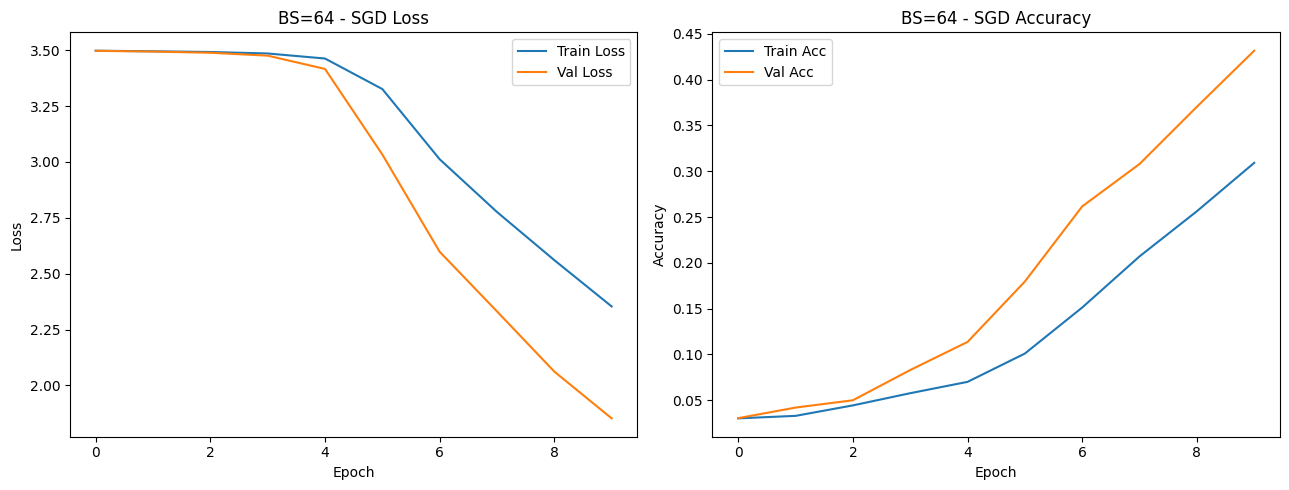


=== Batch: 64 | Optimizer: RMSPROP ===
Epoch 1 | Train Acc: 0.253 | Val Acc: 0.407 | LR: 0.00100
Epoch 2 | Train Acc: 0.499 | Val Acc: 0.555 | LR: 0.00100
Epoch 3 | Train Acc: 0.599 | Val Acc: 0.665 | LR: 0.00100
Epoch 4 | Train Acc: 0.665 | Val Acc: 0.756 | LR: 0.00100
Epoch 5 | Train Acc: 0.717 | Val Acc: 0.788 | LR: 0.00100
Epoch 6 | Train Acc: 0.745 | Val Acc: 0.798 | LR: 0.00100
Epoch 7 | Train Acc: 0.769 | Val Acc: 0.848 | LR: 0.00100
Epoch 8 | Train Acc: 0.794 | Val Acc: 0.874 | LR: 0.00100
Epoch 9 | Train Acc: 0.811 | Val Acc: 0.858 | LR: 0.00100
Epoch 10 | Train Acc: 0.825 | Val Acc: 0.879 | LR: 0.00100


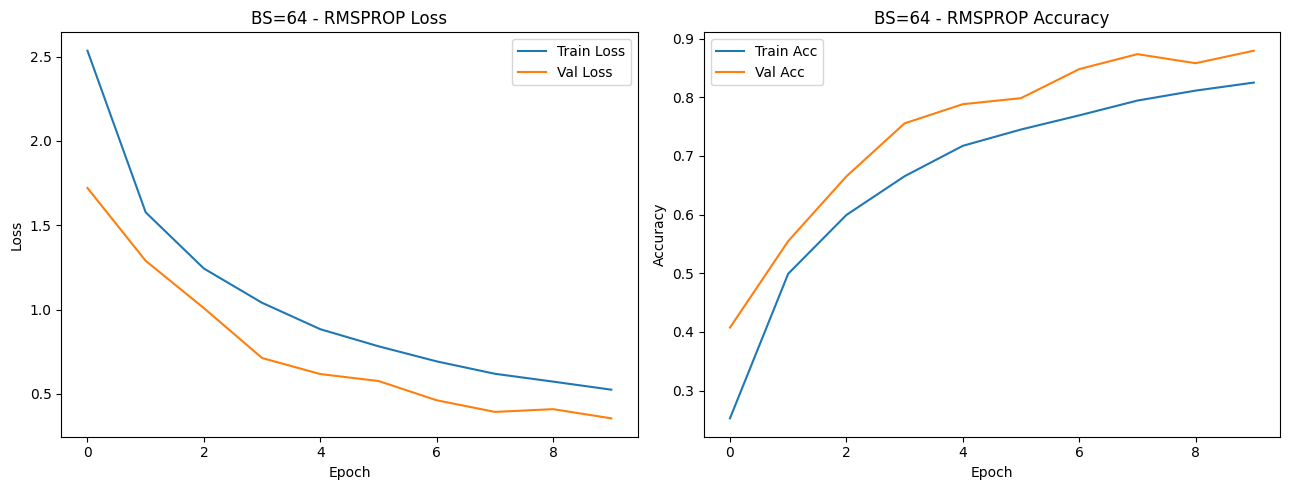


=== Batch: 64 | Optimizer: ADAGRAD ===
Epoch 1 | Train Acc: 0.093 | Val Acc: 0.167 | LR: 0.00100
Epoch 2 | Train Acc: 0.168 | Val Acc: 0.256 | LR: 0.00100
Epoch 3 | Train Acc: 0.202 | Val Acc: 0.297 | LR: 0.00100
Epoch 4 | Train Acc: 0.226 | Val Acc: 0.323 | LR: 0.00100
Epoch 5 | Train Acc: 0.237 | Val Acc: 0.327 | LR: 0.00100
Epoch 6 | Train Acc: 0.252 | Val Acc: 0.350 | LR: 0.00100
Epoch 7 | Train Acc: 0.258 | Val Acc: 0.356 | LR: 0.00100
Epoch 8 | Train Acc: 0.268 | Val Acc: 0.374 | LR: 0.00100
Epoch 9 | Train Acc: 0.276 | Val Acc: 0.376 | LR: 0.00100
Epoch 10 | Train Acc: 0.280 | Val Acc: 0.392 | LR: 0.00100


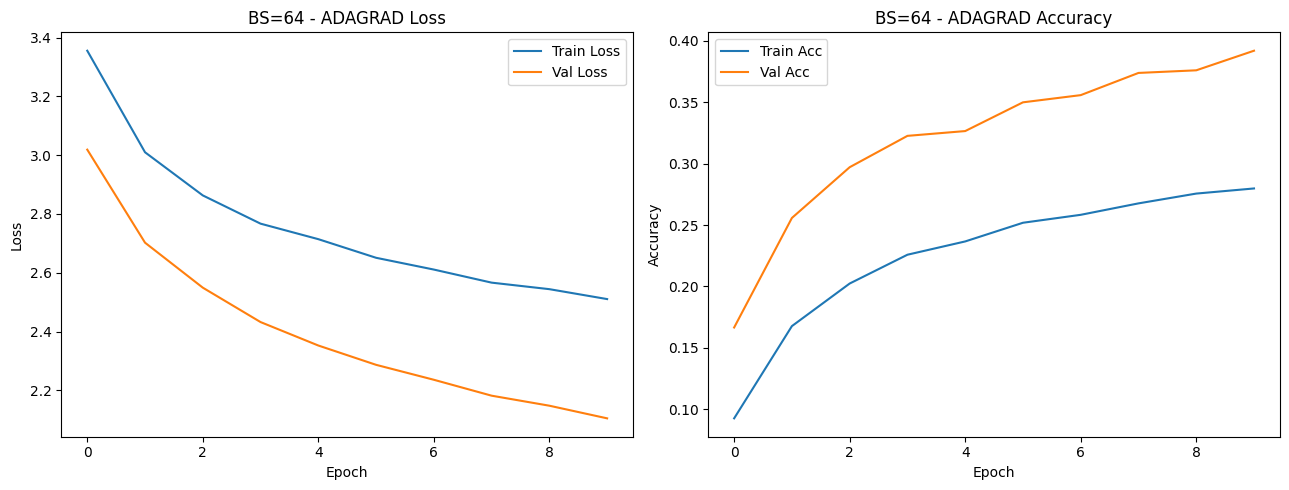


=== Batch: 64 | Optimizer: ADADELTA ===
Epoch 1 | Train Acc: 0.031 | Val Acc: 0.033 | LR: 0.00100
Epoch 2 | Train Acc: 0.031 | Val Acc: 0.034 | LR: 0.00100
Epoch 3 | Train Acc: 0.031 | Val Acc: 0.034 | LR: 0.00100
Epoch 4 | Train Acc: 0.033 | Val Acc: 0.035 | LR: 0.00100
Epoch 5 | Train Acc: 0.032 | Val Acc: 0.037 | LR: 0.00100
Epoch 6 | Train Acc: 0.033 | Val Acc: 0.038 | LR: 0.00100
Epoch 7 | Train Acc: 0.033 | Val Acc: 0.040 | LR: 0.00100
Epoch 8 | Train Acc: 0.034 | Val Acc: 0.041 | LR: 0.00100
Epoch 9 | Train Acc: 0.034 | Val Acc: 0.042 | LR: 0.00100
Epoch 10 | Train Acc: 0.035 | Val Acc: 0.043 | LR: 0.00100


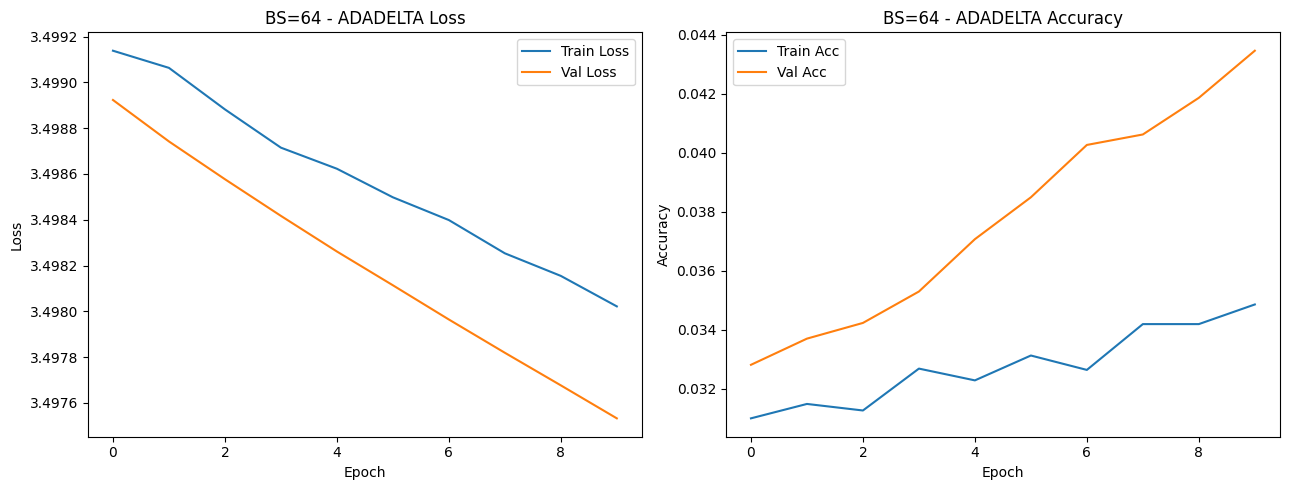

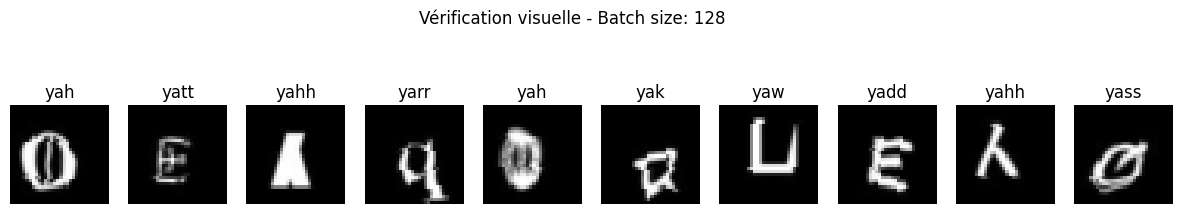


=== Batch: 128 | Optimizer: ADAM ===
Epoch 1 | Train Acc: 0.160 | Val Acc: 0.368 | LR: 0.00100
Epoch 2 | Train Acc: 0.370 | Val Acc: 0.549 | LR: 0.00100
Epoch 3 | Train Acc: 0.501 | Val Acc: 0.623 | LR: 0.00100
Epoch 4 | Train Acc: 0.585 | Val Acc: 0.704 | LR: 0.00100
Epoch 5 | Train Acc: 0.642 | Val Acc: 0.716 | LR: 0.00100
Epoch 6 | Train Acc: 0.684 | Val Acc: 0.755 | LR: 0.00100
Epoch 7 | Train Acc: 0.706 | Val Acc: 0.815 | LR: 0.00100
Epoch 8 | Train Acc: 0.743 | Val Acc: 0.837 | LR: 0.00100
Epoch 9 | Train Acc: 0.765 | Val Acc: 0.827 | LR: 0.00100
Epoch 10 | Train Acc: 0.773 | Val Acc: 0.855 | LR: 0.00100


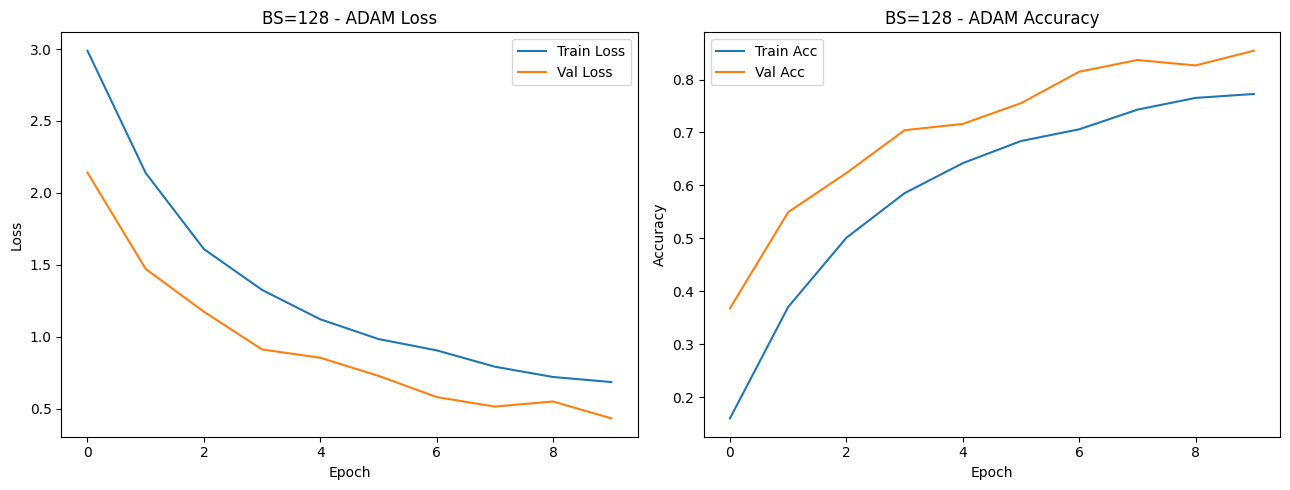


=== Batch: 128 | Optimizer: SGD ===
Epoch 1 | Train Acc: 0.031 | Val Acc: 0.028 | LR: 0.00100
Epoch 2 | Train Acc: 0.031 | Val Acc: 0.028 | LR: 0.00100
Epoch 3 | Train Acc: 0.031 | Val Acc: 0.028 | LR: 0.00100
Epoch 4 | Train Acc: 0.031 | Val Acc: 0.028 | LR: 0.00100
Epoch 5 | Train Acc: 0.031 | Val Acc: 0.028 | LR: 0.00100
Epoch 6 | Train Acc: 0.031 | Val Acc: 0.029 | LR: 0.00100
Epoch 7 | Train Acc: 0.031 | Val Acc: 0.029 | LR: 0.00100
Epoch 8 | Train Acc: 0.031 | Val Acc: 0.030 | LR: 0.00100
Epoch 9 | Train Acc: 0.031 | Val Acc: 0.031 | LR: 0.00100
Epoch 10 | Train Acc: 0.033 | Val Acc: 0.032 | LR: 0.00100


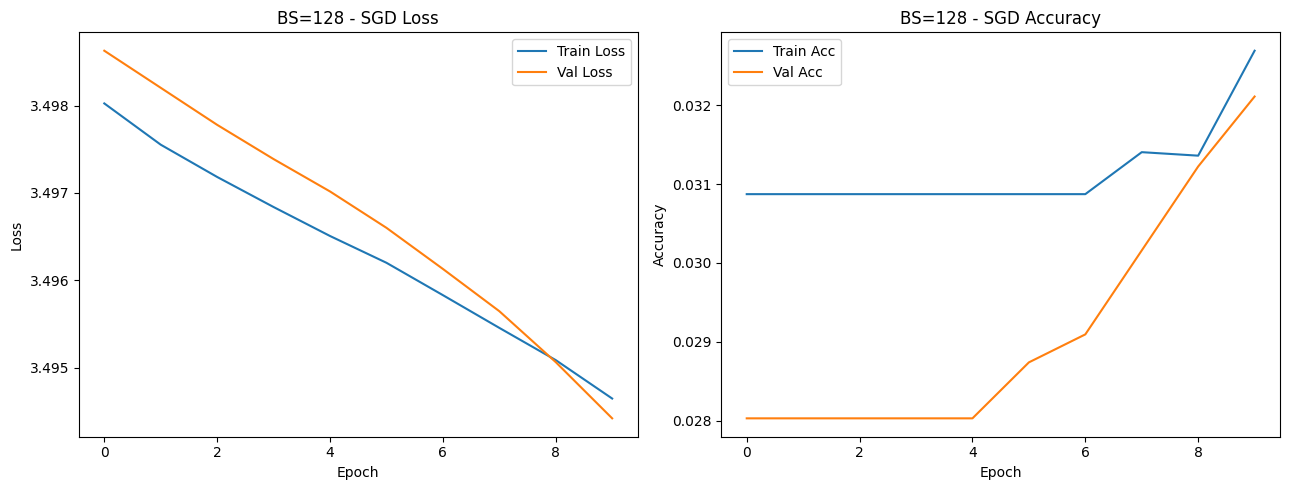


=== Batch: 128 | Optimizer: RMSPROP ===
Epoch 1 | Train Acc: 0.189 | Val Acc: 0.286 | LR: 0.00100
Epoch 2 | Train Acc: 0.395 | Val Acc: 0.390 | LR: 0.00100
Epoch 3 | Train Acc: 0.516 | Val Acc: 0.530 | LR: 0.00100
Epoch 4 | Train Acc: 0.579 | Val Acc: 0.613 | LR: 0.00100
Epoch 5 | Train Acc: 0.635 | Val Acc: 0.690 | LR: 0.00100
Epoch 6 | Train Acc: 0.672 | Val Acc: 0.371 | LR: 0.00100
Epoch 7 | Train Acc: 0.703 | Val Acc: 0.736 | LR: 0.00100
Epoch 8 | Train Acc: 0.730 | Val Acc: 0.758 | LR: 0.00100
Epoch 9 | Train Acc: 0.750 | Val Acc: 0.668 | LR: 0.00100
Epoch 10 | Train Acc: 0.773 | Val Acc: 0.781 | LR: 0.00100


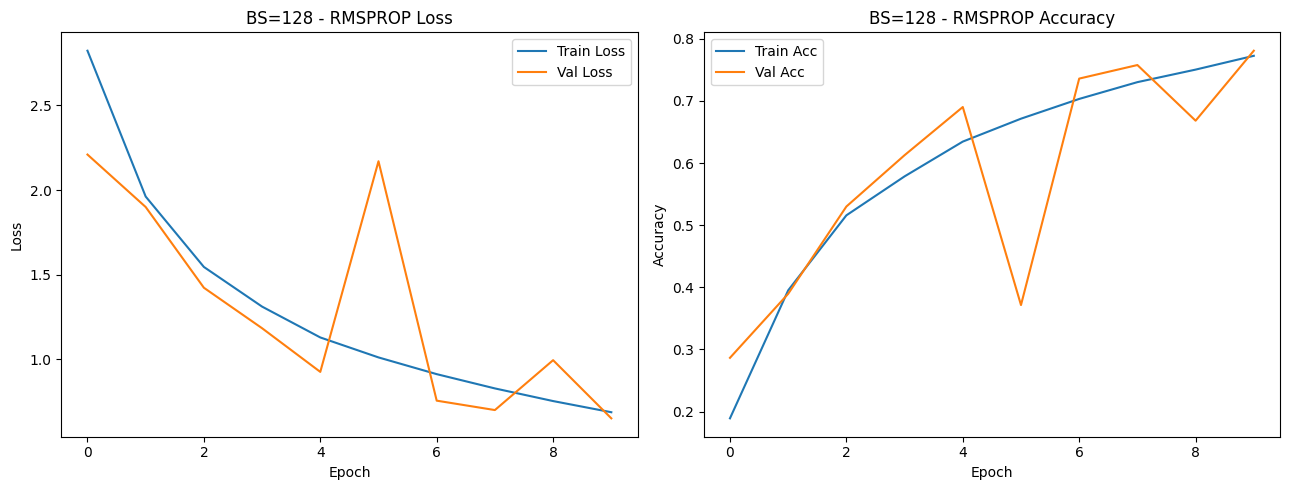


=== Batch: 128 | Optimizer: ADAGRAD ===
Epoch 1 | Train Acc: 0.061 | Val Acc: 0.087 | LR: 0.00100
Epoch 2 | Train Acc: 0.118 | Val Acc: 0.172 | LR: 0.00100
Epoch 3 | Train Acc: 0.147 | Val Acc: 0.200 | LR: 0.00100
Epoch 4 | Train Acc: 0.168 | Val Acc: 0.224 | LR: 0.00100
Epoch 5 | Train Acc: 0.179 | Val Acc: 0.247 | LR: 0.00100
Epoch 6 | Train Acc: 0.194 | Val Acc: 0.279 | LR: 0.00100
Epoch 7 | Train Acc: 0.208 | Val Acc: 0.302 | LR: 0.00100
Epoch 8 | Train Acc: 0.218 | Val Acc: 0.295 | LR: 0.00100
Epoch 9 | Train Acc: 0.224 | Val Acc: 0.306 | LR: 0.00100
Epoch 10 | Train Acc: 0.240 | Val Acc: 0.318 | LR: 0.00100


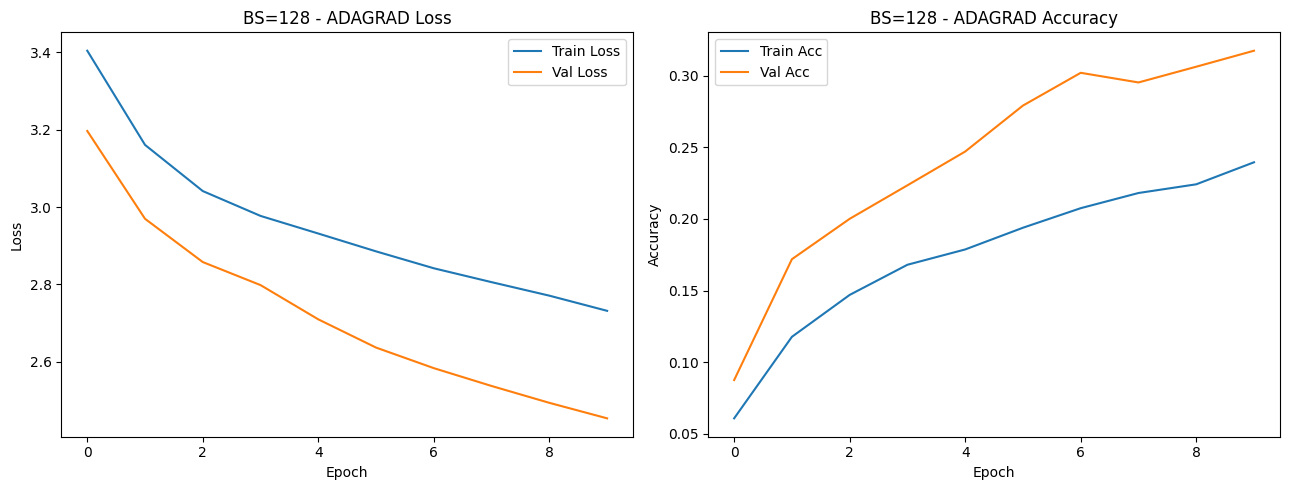


=== Batch: 128 | Optimizer: ADADELTA ===
Epoch 1 | Train Acc: 0.022 | Val Acc: 0.015 | LR: 0.00100
Epoch 2 | Train Acc: 0.022 | Val Acc: 0.016 | LR: 0.00100
Epoch 3 | Train Acc: 0.022 | Val Acc: 0.017 | LR: 0.00100
Epoch 4 | Train Acc: 0.024 | Val Acc: 0.018 | LR: 0.00100
Epoch 5 | Train Acc: 0.025 | Val Acc: 0.022 | LR: 0.00100
Epoch 6 | Train Acc: 0.027 | Val Acc: 0.024 | LR: 0.00100
Epoch 7 | Train Acc: 0.030 | Val Acc: 0.024 | LR: 0.00100
Epoch 8 | Train Acc: 0.029 | Val Acc: 0.023 | LR: 0.00100
Epoch 9 | Train Acc: 0.029 | Val Acc: 0.022 | LR: 0.00100
Epoch 10 | Train Acc: 0.031 | Val Acc: 0.022 | LR: 0.00100


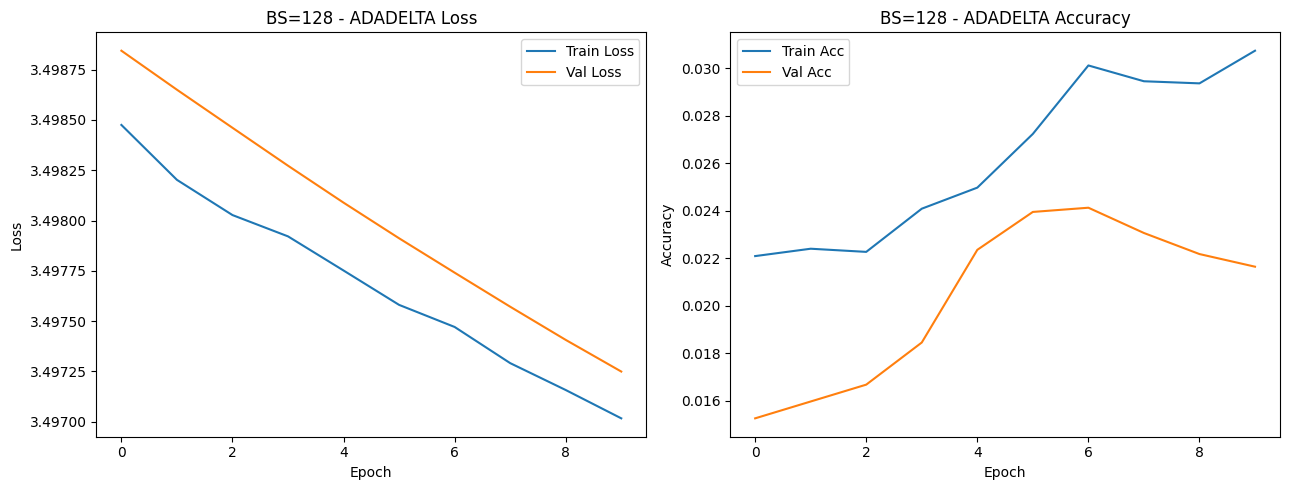

In [ ]:
# =============================
# 7. Boucle d'Expérimentation
# =============================
#batch_sizes = [64]
batch_sizes = [32, 64, 128]

optimizers_to_test = ["adam", "sgd", "rmsprop", "adagrad", "adadelta"]
num_epochs = 10  # Pour voir l'early stopping (à augmenter)
learning_rate = 0.001
patience = 7  # Early stopping patience
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_results = {}
print("Taille train_dataset :", len(train_dataset))
print("Taille test_dataset  :", len(test_dataset))
print("Nombre de classes   :", len(class_names))
print("Exemple 0 :", train_dataset[0] if len(train_dataset) > 0 else "EMPTY")

for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # ===  affichage d'un batch pour contrôle visuel ===
    images, labels = next(iter(train_loader))
    plt.figure(figsize=(15,3))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.suptitle(f"Vérification visuelle - Batch size: {batch_size}")
    plt.show()
    # ==========================================================
    for opt_name in optimizers_to_test:
        print(f"\n=== Batch: {batch_size} | Optimizer: {opt_name.upper()} ===")
        model = LeNet5(num_classes=len(class_names)).to(device)
        optimizer = get_optimizer(opt_name, model.parameters(), lr=learning_rate)
        #scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.5, verbose=True)
        criterion = nn.CrossEntropyLoss()
        train_losses, train_accs, val_losses, val_accs = [], [], [], []
        best_val_acc, best_model_path = 0.0, f'lenet5_best_{opt_name}_bs{batch_size}.pth'
        no_improve_epochs = 0
        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evaluate(model, test_loader, criterion, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            scheduler.step(val_acc)
            print(f"Epoch {epoch+1} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.5f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping à l'epoch {epoch+1} (pas d'amélioration depuis {patience} epochs)")
                break
        key = (batch_size, opt_name)
        all_results[key] = {
            'train_losses': train_losses, 'val_losses': val_losses,
            'train_accs': train_accs, 'val_accs': val_accs,
            'best_val_acc': best_val_acc, 'best_model_path': best_model_path
        }
        # Courbes
        plt.figure(figsize=(13,5))
        plt.subplot(1,2,1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
        plt.title(f"BS={batch_size} - {opt_name.upper()} Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
        plt.subplot(1,2,2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
        plt.title(f"BS={batch_size} - {opt_name.upper()} Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
        plt.tight_layout(); plt.show()

In [ ]:
# =============================
# 8. Résumé CSV & Sélection du Meilleur Modèle
# =============================
summary = []
for (batch_size, opt_name), res in all_results.items():
    summary.append({
        'batch_size': batch_size,
        'optimizer': opt_name,
        'best_val_acc': res['best_val_acc'],
        'best_model_path': res['best_model_path']
    })
df_summary = pd.DataFrame(summary)
print(df_summary.sort_values('best_val_acc', ascending=False))
df_summary.to_csv("resume_experiences.csv", index=False)

# Sélection automatique du meilleur modèle
best_row = df_summary.loc[df_summary["best_val_acc"].idxmax()]
best_model_path = best_row["best_model_path"]
best_batch_size = best_row['batch_size']
best_optimizer = best_row['optimizer']
print(f"\nChargement du meilleur modèle : {best_model_path} (Acc={best_row['best_val_acc']:.4f}, batch={best_batch_size}, opt={best_optimizer})")
best_batch_size = int(best_batch_size)
best_test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
model = LeNet5(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

    batch_size optimizer  best_val_acc                 best_model_path
0           32      adam      0.930459       lenet5_best_adam_bs32.pth
2           32   rmsprop      0.914671    lenet5_best_rmsprop_bs32.pth
5           64      adam      0.909349       lenet5_best_adam_bs64.pth
7           64   rmsprop      0.879368    lenet5_best_rmsprop_bs64.pth
10         128      adam      0.854533      lenet5_best_adam_bs128.pth
12         128   rmsprop      0.780912   lenet5_best_rmsprop_bs128.pth
1           32       sgd      0.672521        lenet5_best_sgd_bs32.pth
6           64       sgd      0.431613        lenet5_best_sgd_bs64.pth
8           64   adagrad      0.392053    lenet5_best_adagrad_bs64.pth
3           32   adagrad      0.359234    lenet5_best_adagrad_bs32.pth
13         128   adagrad      0.317545   lenet5_best_adagrad_bs128.pth
4           32  adadelta      0.048785   lenet5_best_adadelta_bs32.pth
9           64  adadelta      0.043463   lenet5_best_adadelta_bs64.pth
11    

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=33, bias=True)
)

<Figure size 1200x1200 with 0 Axes>

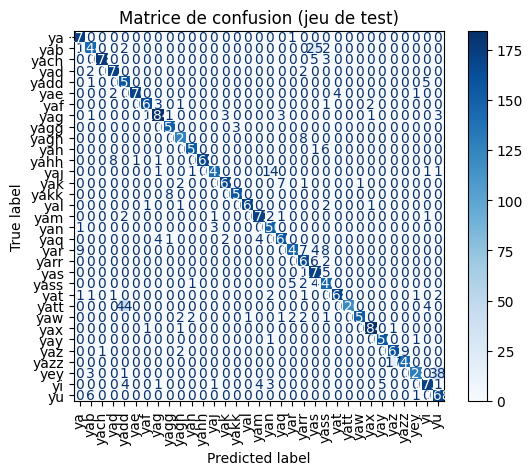

In [ ]:
# =============================
# Bloc : Matrice de confusion
# =============================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in best_test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(12, 12))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Matrice de confusion (jeu de test)")
plt.show()

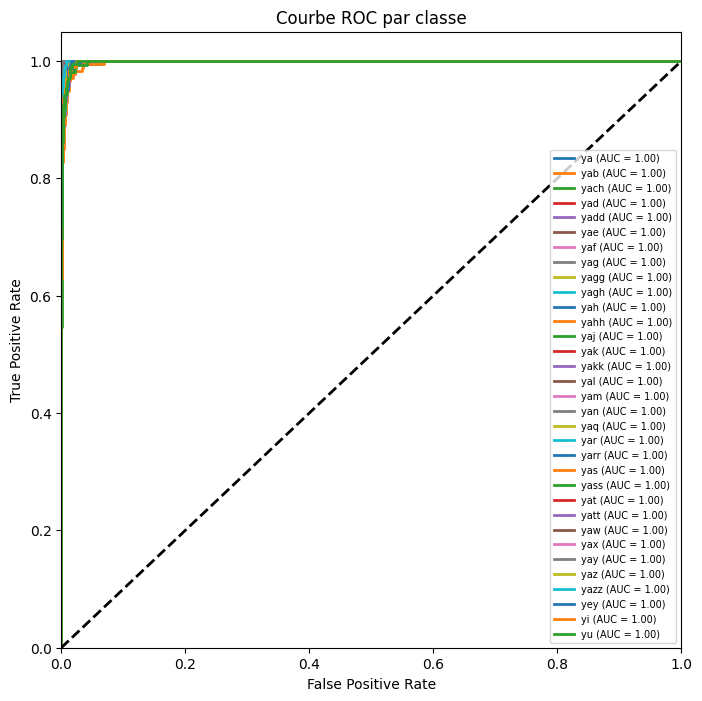

In [ ]:
# =============================
# Bloc : ROC/AUC multiclasses
# =============================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

all_probs, all_labels = [], []
with torch.no_grad():
    for images, labels in best_test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()
y_true = label_binarize(all_labels, classes=list(range(len(class_names))))
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8,8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC par classe')
plt.legend(loc="lower right", fontsize=7)
plt.show()

Nombre d'exemples mal classés : 392


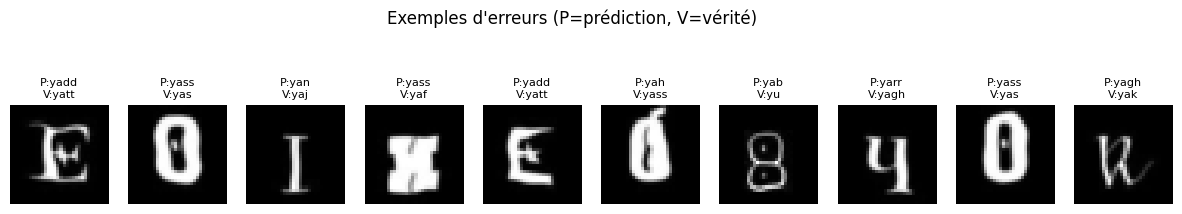

In [ ]:
# =============================
# Bloc : Affichage d'exemples mal classés
# =============================
errors = []
model.eval()
with torch.no_grad():
    for images, labels in best_test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if predicted[i] != labels[i]:
                errors.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
print(f"Nombre d'exemples mal classés : {len(errors)}")
plt.figure(figsize=(15,3))
for idx, (img, label, pred) in enumerate(errors[:10]):
    plt.subplot(1, 10, idx+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"P:{class_names[pred]}\nV:{class_names[label]}", fontsize=8)
    plt.axis('off')
plt.suptitle("Exemples d'erreurs (P=prédiction, V=vérité)")
plt.show()

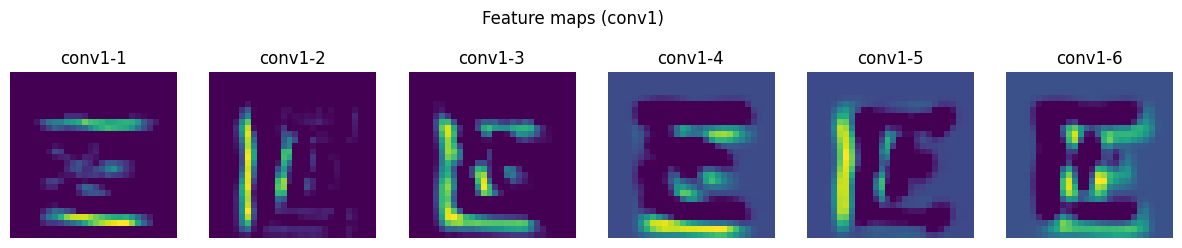

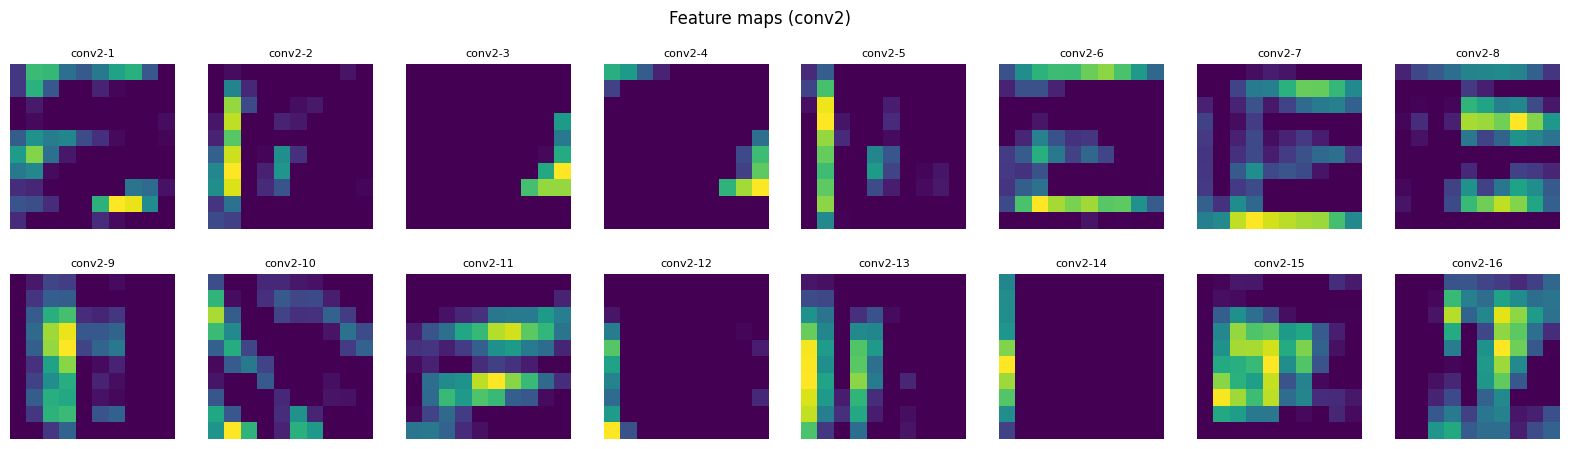

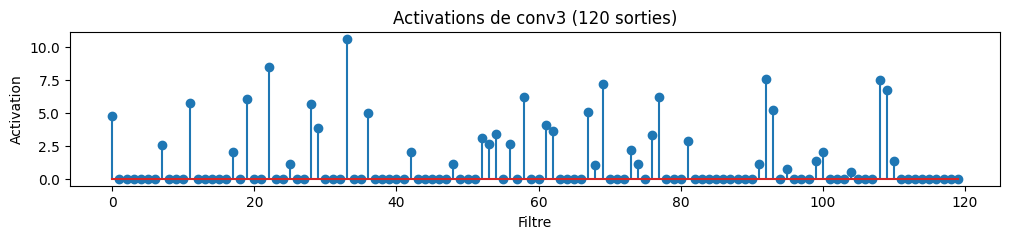

In [ ]:
# =============================
# Bloc : Feature maps d'une image du test set
# =============================
def plot_feature_maps(model, image_tensor, device):
    model.eval()
    x = image_tensor.to(device)
    with torch.no_grad():
        feat1 = F.relu(model.conv1(x))
        feat2 = F.relu(model.conv2(model.pool1(feat1)))
        feat3 = F.relu(model.conv3(model.pool2(feat2)))
    plt.figure(figsize=(15,3))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(feat1[0,i].cpu(), cmap='viridis')
        plt.axis('off')
        plt.title(f'conv1-{i+1}')
    plt.suptitle("Feature maps (conv1)")
    plt.show()
    plt.figure(figsize=(20,5))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(feat2[0,i].cpu(), cmap='viridis')
        plt.axis('off')
        plt.title(f'conv2-{i+1}', fontsize=8)
    plt.suptitle("Feature maps (conv2)")
    plt.show()
    feat3_flat = feat3[0,:,0,0].cpu().numpy()
    plt.figure(figsize=(12,2))
    plt.stem(feat3_flat)
    plt.title("Activations de conv3 (120 sorties)")
    plt.xlabel("Filtre")
    plt.ylabel("Activation")
    plt.show()
img, lbl = test_dataset[0]
img = img.unsqueeze(0)
plot_feature_maps(model, img, device)

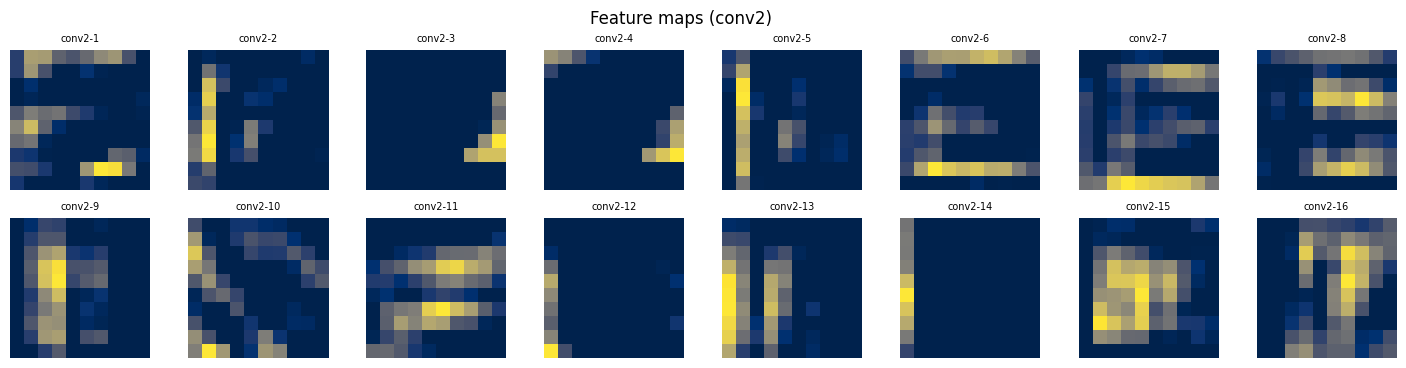

In [ ]:
# ===========================================
# Bloc : Affichage grille compacte de conv2
# ===========================================
def plot_feature_grid(feat_tensor, layer_name='conv2'):
    num_maps = feat_tensor.shape[1]
    rows = int(np.ceil(num_maps/8))
    plt.figure(figsize=(18, rows*2))
    for i in range(num_maps):
        plt.subplot(rows, 8, i+1)
        plt.imshow(feat_tensor[0,i].cpu(), cmap='cividis')
        plt.axis('off')
        plt.title(f'{layer_name}-{i+1}', fontsize=7)
    plt.suptitle(f'Feature maps ({layer_name})')
    plt.show()

# Exemple
with torch.no_grad():
    feat2 = F.relu(model.conv2(model.pool1(F.relu(model.conv1(img.to(device))))))
plot_feature_grid(feat2, 'conv2')

Classe vraie : yatt


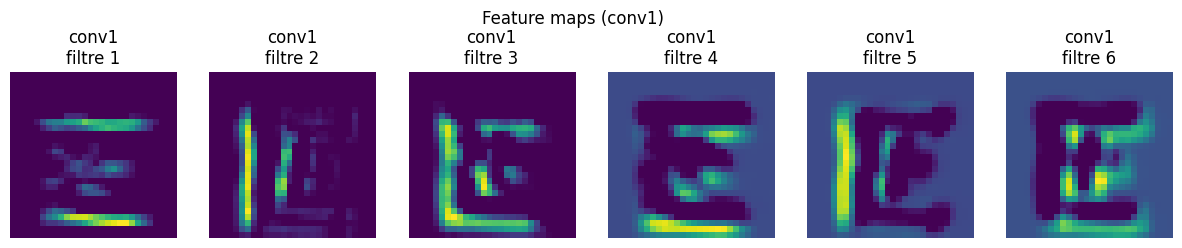

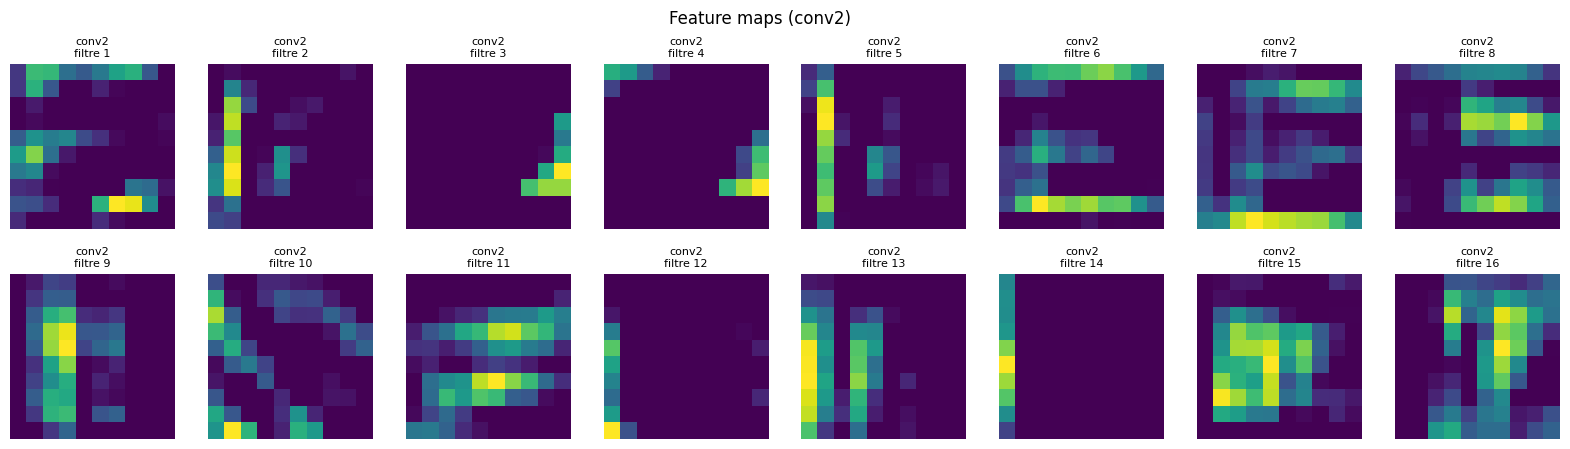

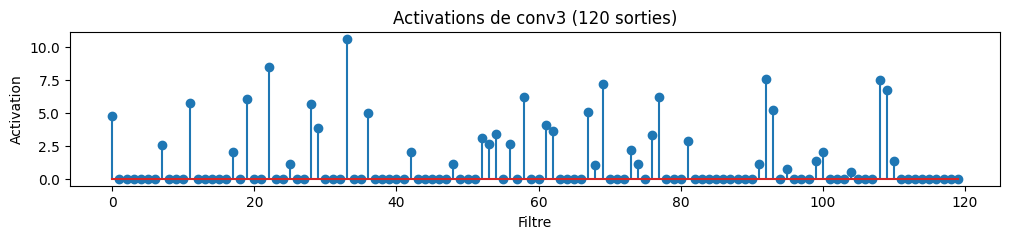

In [ ]:
# ===========================================
# Bloc : Visualisation des feature maps dans LeNet-5
# ===========================================

def plot_feature_maps(model, image_tensor, device, class_names):
    """
    Affiche les feature maps de chaque couche convolutionnelle du modèle LeNet-5
    pour une image donnée (tensor shape : 1x1x32x32)
    """
    model.eval()
    x = image_tensor.to(device)
    with torch.no_grad():
        # Passage dans chaque couche convolutionnelle
        feat1 = model.conv1(x)  # (1, 6, 28, 28)
        feat1_act = F.relu(feat1)
        feat2 = model.conv2(model.pool1(feat1_act))  # (1, 16, 10, 10)
        feat2_act = F.relu(feat2)
        feat3 = model.conv3(model.pool2(feat2_act))  # (1, 120, 1, 1)
        feat3_act = F.relu(feat3)

    # Affichage des feature maps de conv1 (6 maps)
    plt.figure(figsize=(15,3))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(feat1_act[0,i].cpu(), cmap='viridis')
        plt.axis('off')
        plt.title(f'conv1\nfiltre {i+1}')
    plt.suptitle("Feature maps (conv1)")
    plt.show()

    # Affichage des feature maps de conv2 (16 maps)
    plt.figure(figsize=(20,5))
    for i in range(16):
        plt.subplot(2, 8, i+1)
        plt.imshow(feat2_act[0,i].cpu(), cmap='viridis')
        plt.axis('off')
        plt.title(f'conv2\nfiltre {i+1}', fontsize=8)
    plt.suptitle("Feature maps (conv2)")
    plt.show()

    # Affichage des feature maps de conv3 (120 maps, 1x1)
    feat3_flat = feat3_act[0,:,0,0].cpu().numpy()
    plt.figure(figsize=(12,2))
    plt.stem(feat3_flat)
    plt.title("Activations de conv3 (120 sorties)")
    plt.xlabel("Filtre")
    plt.ylabel("Activation")
    plt.show()

# ===========================================
# Exemple d’utilisation sur une image du test set :
# ===========================================

# Prendre une image du test set
test_images, test_labels = next(iter(test_loader))
img = test_images[0].unsqueeze(0)  # Garde batch dimension
lbl = test_labels[0]
print(f"Classe vraie : {class_names[lbl]}")
plot_feature_maps(model, img, device, class_names)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

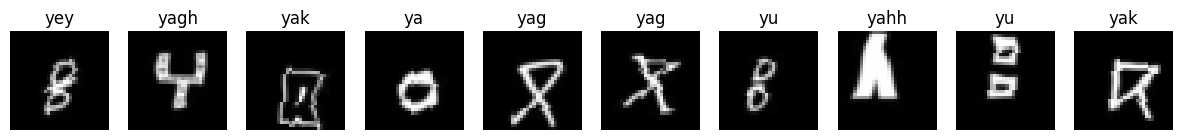

In [ ]:
# =============================
# 9. Vérification Affichage d'Images (10 exemples train)
# =============================
images, labels = next(iter(DataLoader(train_dataset, batch_size=10, shuffle=True)))
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt


Classe : ya — 1 erreurs


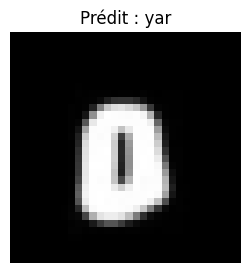


Classe : yab — 30 erreurs


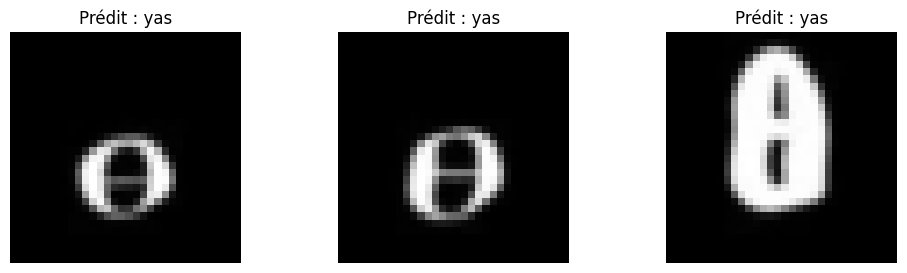


Classe : yach — 8 erreurs


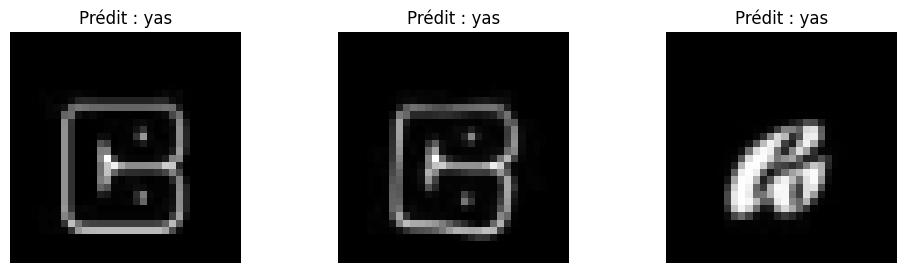


Classe : yad — 4 erreurs


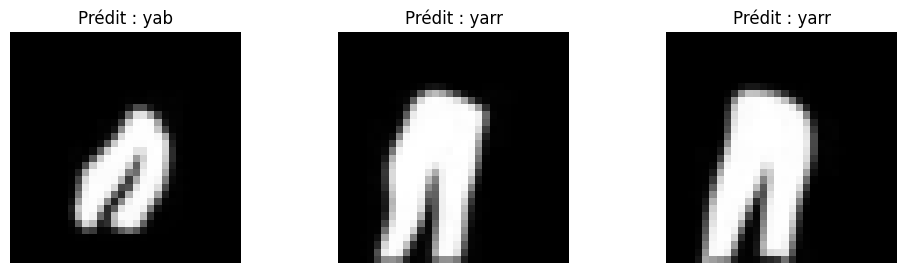


Classe : yadd — 6 erreurs


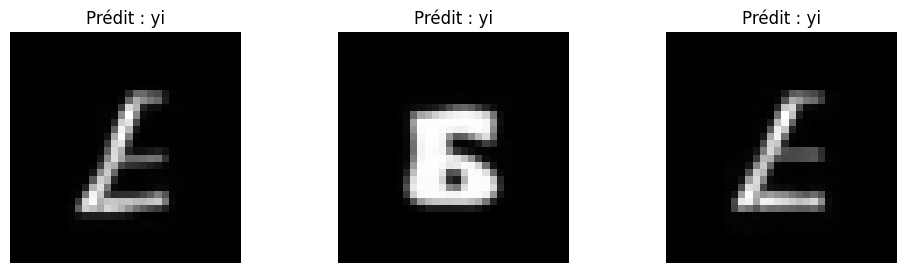


Classe : yae — 7 erreurs


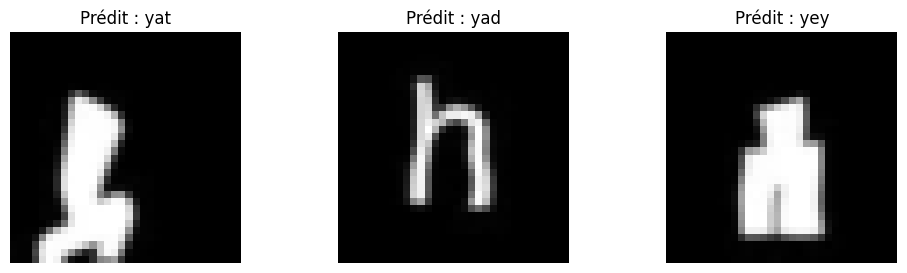


Classe : yaf — 7 erreurs


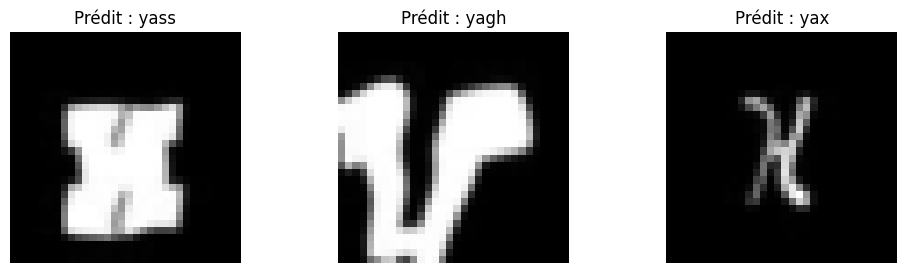


Classe : yag — 13 erreurs


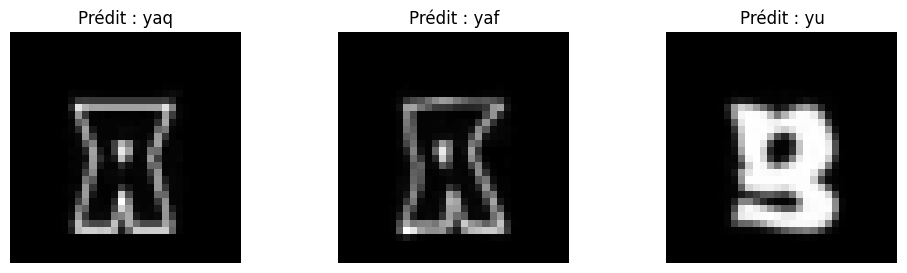


Classe : yagg — 3 erreurs


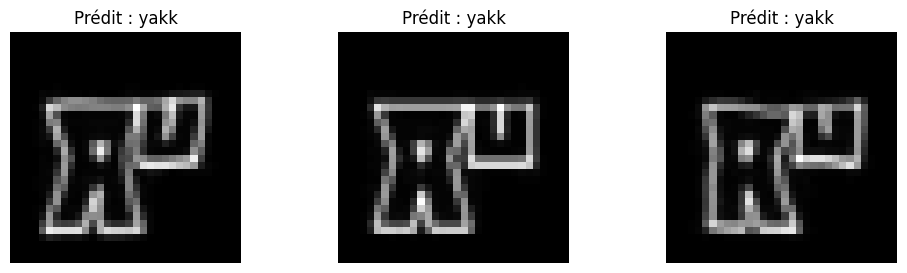


Classe : yagh — 8 erreurs


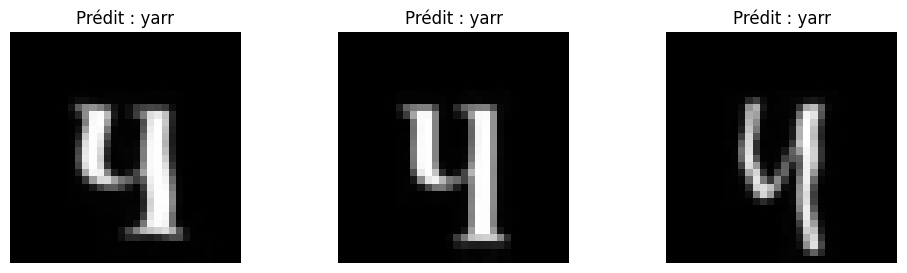


Classe : yah — 7 erreurs


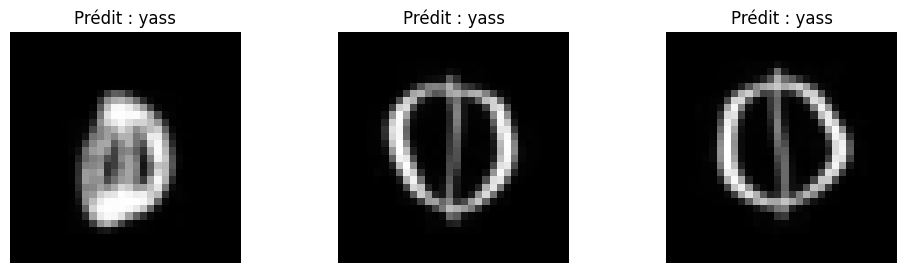


Classe : yahh — 10 erreurs


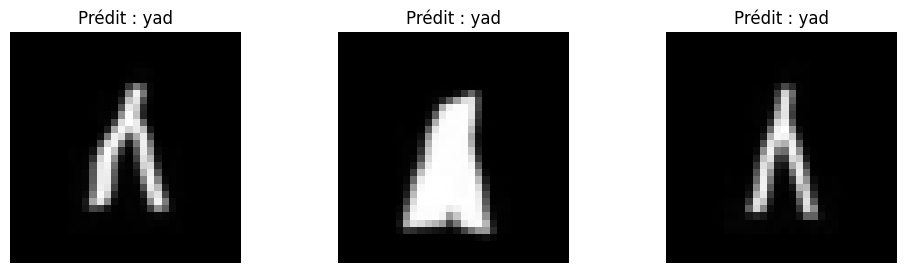


Classe : yaj — 18 erreurs


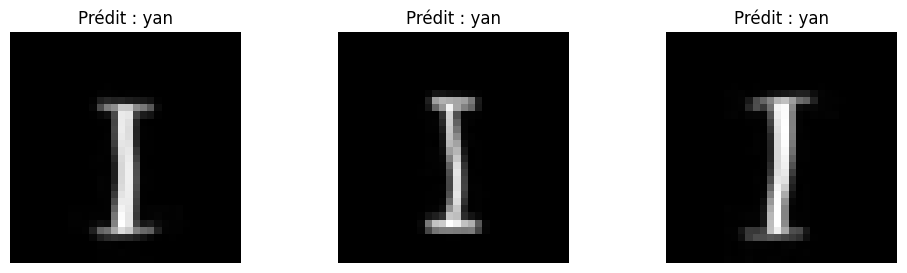


Classe : yak — 11 erreurs


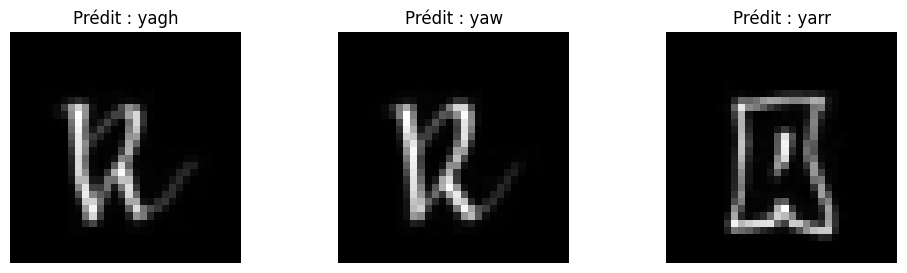


Classe : yakk — 8 erreurs


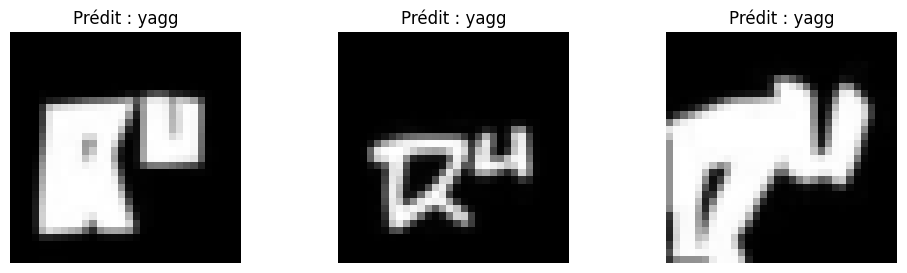


Classe : yal — 5 erreurs


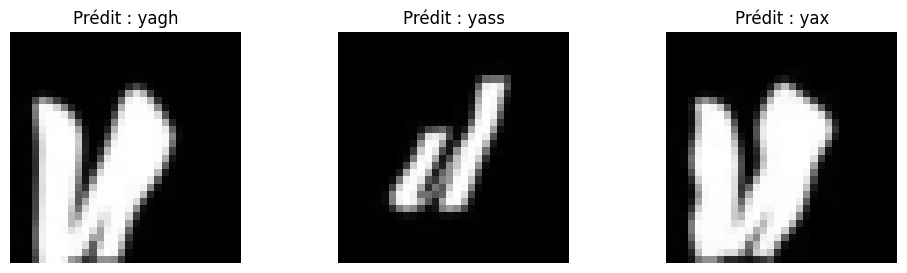


Classe : yam — 7 erreurs


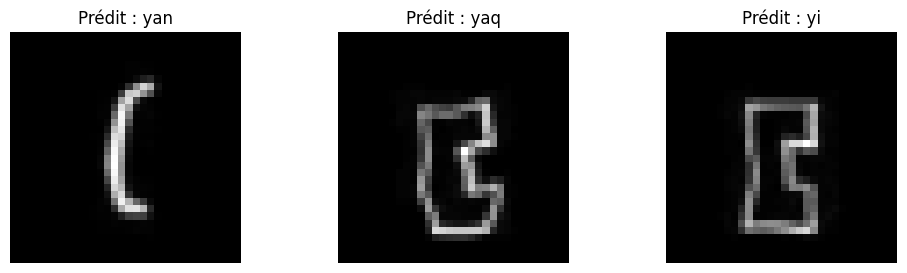


Classe : yan — 4 erreurs


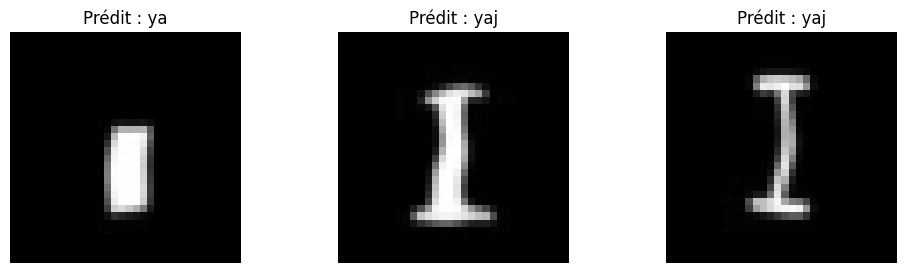


Classe : yaq — 11 erreurs


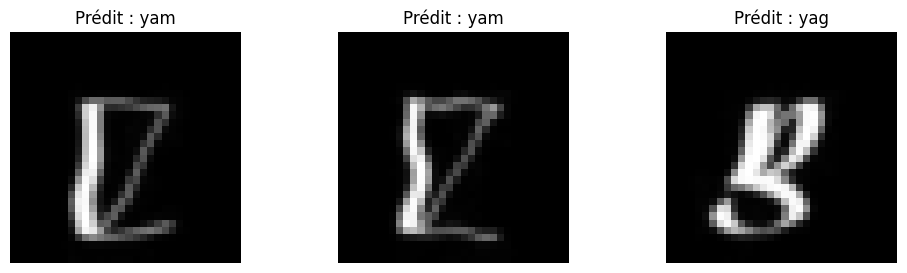


Classe : yar — 28 erreurs


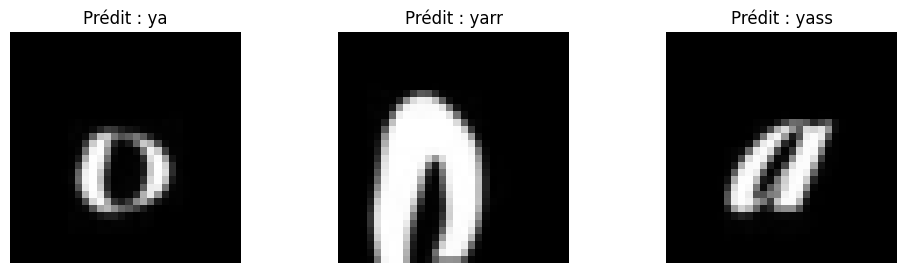


Classe : yarr — 8 erreurs


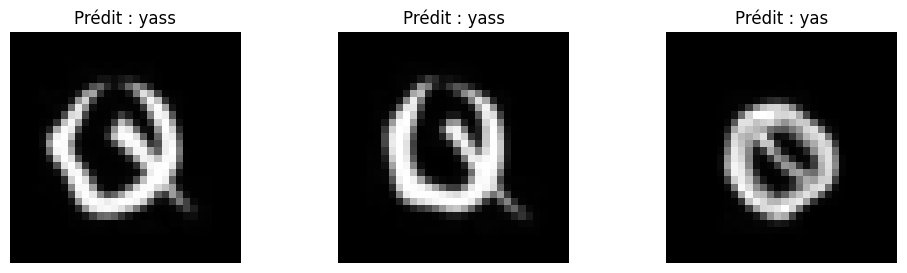


Classe : yas — 6 erreurs


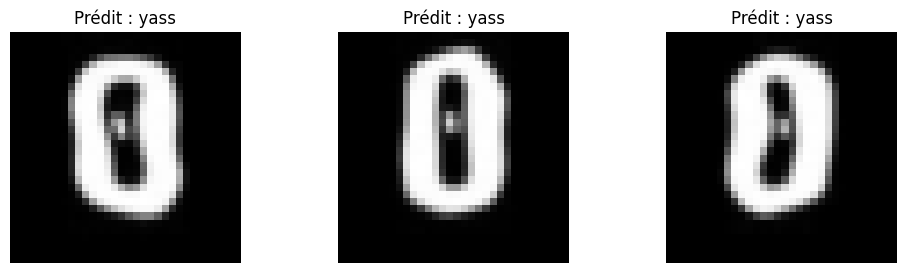


Classe : yass — 12 erreurs


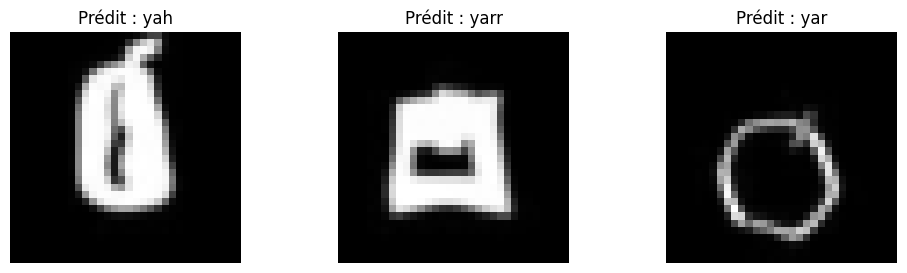


Classe : yat — 9 erreurs


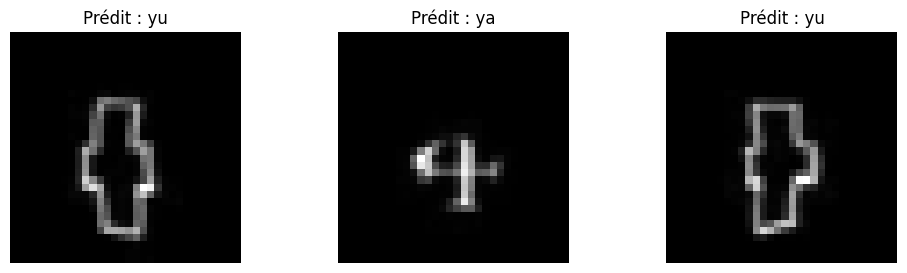


Classe : yatt — 48 erreurs


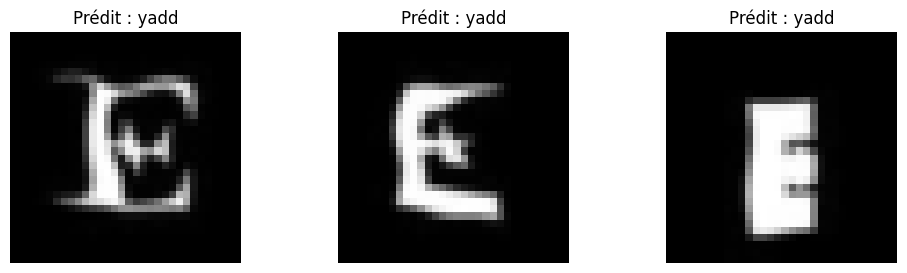


Classe : yaw — 11 erreurs


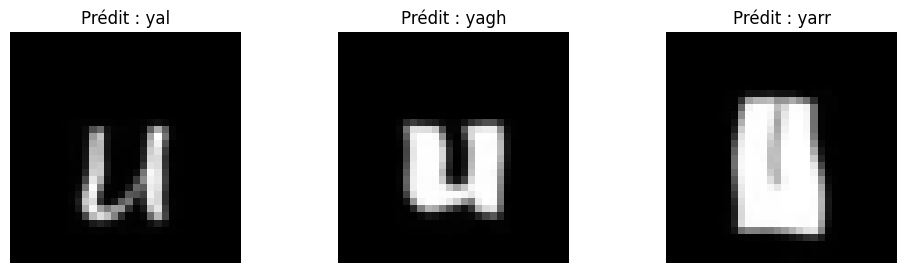


Classe : yax — 3 erreurs


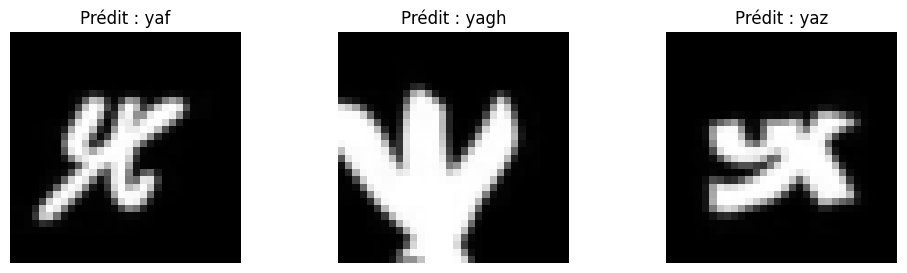


Classe : yay — 2 erreurs


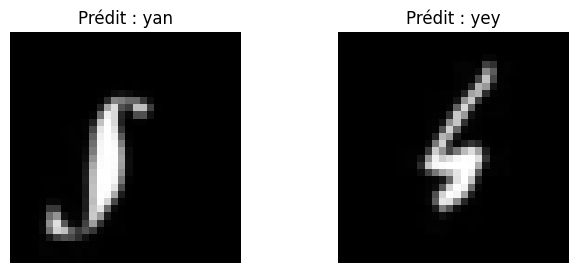


Classe : yaz — 12 erreurs


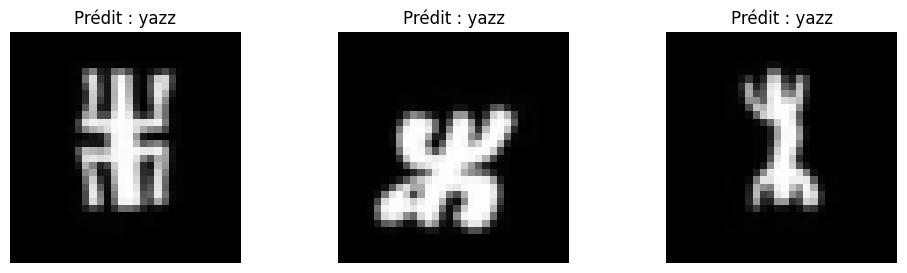


Classe : yazz — 17 erreurs


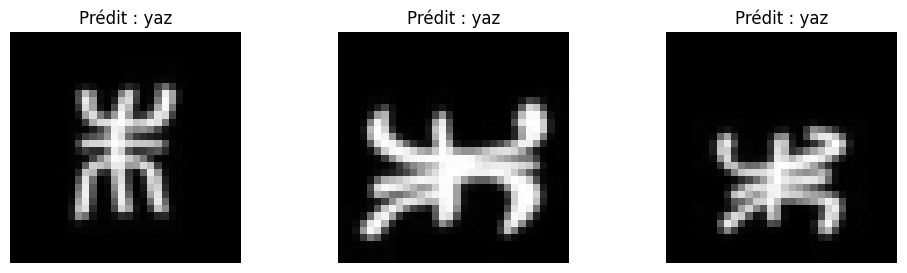


Classe : yey — 42 erreurs


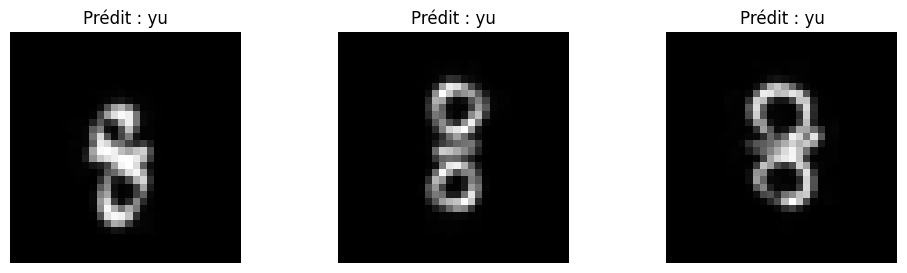


Classe : yi — 19 erreurs


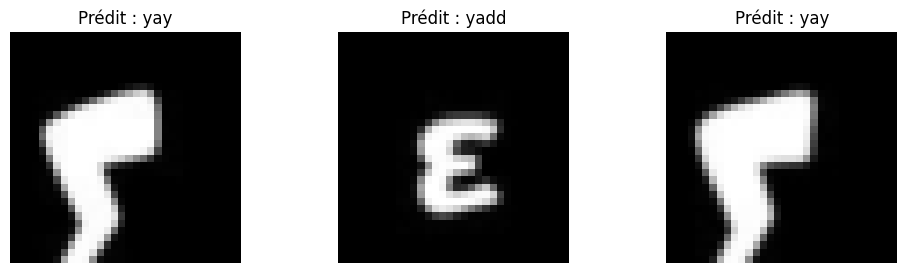


Classe : yu — 7 erreurs


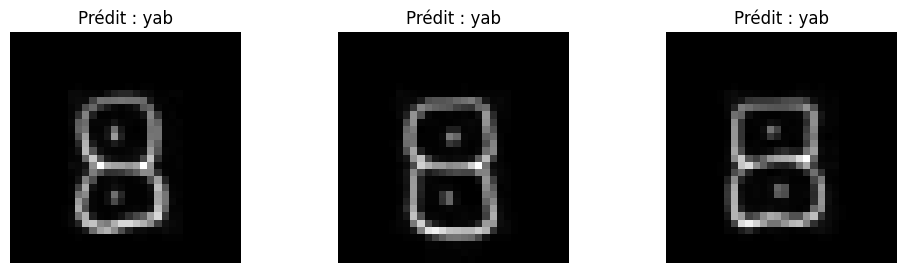

In [ ]:
# ===========================================
# Bloc  : Affichage des erreurs fréquentes par classe
# ===========================================

import collections

# Compter les erreurs par classe vraie
error_stats = collections.defaultdict(list)
for img, label, pred in errors:
    error_stats[label].append((img, pred))

# Afficher les 3 pires erreurs pour chaque classe (maximum 3 images par classe)
for label in range(len(class_names)):
    if len(error_stats[label]) > 0:
        print(f"\nClasse : {class_names[label]} — {len(error_stats[label])} erreurs")
        plt.figure(figsize=(12,3))
        for i, (img, pred) in enumerate(error_stats[label][:3]):
            plt.subplot(1, 3, i+1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f"Prédit : {class_names[pred]}")
            plt.axis('off')
        plt.show()

Saving png-clipart-tifinagh-berber-languages-wikipedia-berbers-alphabet-e-miscellaneous-text-thumbnail.png to png-clipart-tifinagh-berber-languages-wikipedia-berbers-alphabet-e-miscellaneous-text-thumbnail (1).png
Classe prédite : yaz


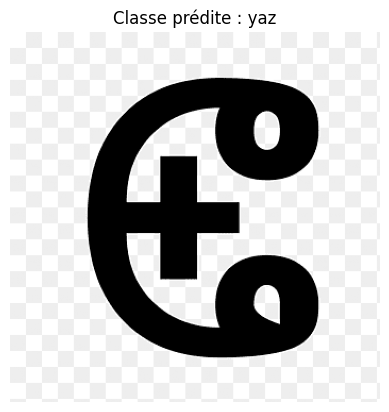

In [ ]:
# ===========================================
# Bloc : Prédire la classe d'une image importée par l'utilisateur
# ===========================================
from google.colab import files
from PIL import Image
import torch

# Uploader une image
uploaded = files.upload()
img_path = next(iter(uploaded))

# Prétraitement identique au dataset
img = Image.open(img_path).convert('L')
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
img_tensor = transform(img).unsqueeze(0).to(device)  # Ajouter batch dimension

# Prédiction
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, pred = torch.max(output, 1)
    predicted_class = class_names[pred.item()]    # <--- Correction ici !

print(f"Classe prédite : {predicted_class}")

# Affichage de l'image
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.title(f"Classe prédite : {predicted_class}")
plt.axis('off')
plt.show()